# Single-Label Random Forest Regression

## Section 1: Setup 

In [1]:
# import required packages
import PredictMD
import CSV
import DataFrames
import GZip
import StatsBase

# set the seed of the global random number generator
# this makes the results reproducible
srand(999)

INFO: Precompiling module PredictMD.
Expr(:call, Expr(:., :Base, :include_from_node1)::Any, "/Users/mrestrep/.julia/v0.6/FFTW/src/FFTW.jl")::Any
  ** incremental compilation may be broken for this module **



MersenneTwister(UInt32[0x000003e7], Base.dSFMT.DSFMT_state(Int32[-412893719, 1072748155, -748568654, 1073610384, -1271302057, 1073556021, -429186579, 1073162675, 932796209, 1073458022  …  1115928124, 1073598513, 1280798571, 1072732908, -581554620, 1977796709, 1774936613, -1100988421, 382, 0]), [1.55164, 1.487, 1.85318, 1.95024, 1.20614, 1.39979, 1.29654, 1.25105, 1.08051, 1.08548  …  1.88474, 1.46801, 1.2853, 1.73083, 1.25907, 1.30943, 1.89382, 1.13456, 1.37224, 1.63709], 382)

## Running for the first time

If you are running this file for the first time and/or if you do not have
any trained models saved to disk, uncomment the lines below to train a model and save it to disk

In [2]:
load_pretrained = false
save_trained = true

true

## Using a pre-trained model

If you already have trained models saved, and you would like to load those. Uncomment the lines below

In [3]:
# load_pretrained = true
# save_trained = false

## Set your paths

In [4]:
linearreg_filename = "./linearreg.jld2"
randomforestreg_filename = "./randomforestreg.jld2"
epsilonsvr_svmreg_filename = "./epsilonsvr_svmreg.jld2"
nusvr_svmreg_filename = "./nusvr_svmreg.jld2"
knetmlpreg_filename = "./knetmlpreg.jld2"

"./knetmlpreg.jld2"

## Section 2: Prepare data 

In [5]:
# Import Boston housing data
df = CSV.read(
    GZip.gzopen(joinpath(Pkg.dir("RDatasets"),"data","MASS","Boston.csv.gz")),
    DataFrames.DataFrame,
    )

#take a quick look at file header and few rows
DataFrames.head(df)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat,MedV
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
6,0.02985,0.0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [6]:
# Remove rows with missing data
DataFrames.dropmissing!(df)

# Shuffle rows
PredictMD.shuffle_rows!(df)

# Define labels
categoricalfeaturenames = Symbol[]

continuousfeaturenames = Symbol[
    :Crim,
    :Zn,
    :Indus,
    :Chas,
    :NOx,
    :Rm,
    :Age,
    :Dis,
    :Rad,
    :Tax,
    :PTRatio,
    :Black,
    :LStat,
    ]
featurenames = vcat(categoricalfeaturenames, continuousfeaturenames)

13-element Array{Symbol,1}:
 :Crim   
 :Zn     
 :Indus  
 :Chas   
 :NOx    
 :Rm     
 :Age    
 :Dis    
 :Rad    
 :Tax    
 :PTRatio
 :Black  
 :LStat  

In [7]:
if load_pretrained
else
    contrasts = PredictMD.contrasts(df, featurenames)
end

PredictMD.ImmutableDataFrameFeatureContrasts(Symbol[:Crim, :Zn, :Indus, :Chas, :NOx, :Rm, :Age, :Dis, :Rad, :Tax, :PTRatio, :Black, :LStat], 13, Dict{Symbol,StatsModels.ContrastsMatrix}(), 13)

In [8]:
# Define labels
labelname = :MedV

# Put features and labels in separate dataframes
featuresdf = df[featurenames]
labelsdf = df[[labelname]]

# Display for exploration
display(DataFrames.head(featuresdf))
display(DataFrames.head(labelsdf))

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax,PTRatio,Black,LStat
1,88.9762,0.0,18.1,0,0.671,6.968,91.9,1.4165,24,666,20.2,396.9,17.21
2,0.06047,0.0,2.46,0,0.488,6.153,68.8,3.2797,3,193,17.8,387.11,13.15
3,0.1712,0.0,8.56,0,0.52,5.836,91.9,2.211,5,384,20.9,395.67,18.66
4,0.54452,0.0,21.89,0,0.624,6.151,97.9,1.6687,4,437,21.2,396.9,18.46
5,0.03466,35.0,6.06,0,0.4379,6.031,23.3,6.6407,1,304,16.9,362.25,7.83
6,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.118,4,224,14.7,390.55,2.88


,MedV
1,10.4
2,29.6
3,19.5
4,17.8
5,19.4
6,50.0


In [9]:
# View summary statistics for label variable (mean, quartiles, etc.)
DataFrames.describe(labelsdf[labelname])

Summary Stats:
Mean:           22.532806
Minimum:        5.000000
1st Quartile:   17.025000
Median:         21.200000
3rd Quartile:   25.000000
Maximum:        50.000000
Length:         506
Type:           Union{Float64, Missings.Missing}
Number Missing: 0
% Missing:      0.000000


In [10]:
# Split data into training set (70%) and testing set (30%)
trainingfeaturesdf,testingfeaturesdf,traininglabelsdf,testinglabelsdf =
    PredictMD.split_data(featuresdf,labelsdf;training = 0.7,testing = 0.3,);

## Section 3: Set up and train models 

## Linear regression

In [11]:
# Set up linear regression model
linearreg = PredictMD.singlelabeldataframelinearregression(
    featurenames,
    labelname;
    package = :GLMjl,
    intercept = true, # optional, defaults to true
    name = "Linear regression", # optional
    )

if load_pretrained
    PredictMD.load!(linearreg_filename, linearreg)
else
    # set feature contrasts
    PredictMD.set_feature_contrasts!(linearreg, contrasts)
    # Train linear regression model
    PredictMD.fit!(linearreg,trainingfeaturesdf,traininglabelsdf,)
end

INFO: Starting to train GLM.jl model.
INFO: Finished training GLM.jl model.


PredictMD.MutableGLMjlGeneralizedLinearModelEstimator("", false, true, Formula: MedV ~ 1 + Crim + Zn + Indus + Chas + NOx + Rm + Age + Dis + Rad + Tax + PTRatio + Black + LStat, Distributions.Normal{Float64}(μ=0.0, σ=1.0), GLM.IdentityLink(), StatsModels.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Normal{Float64},GLM.IdentityLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: MedV ~ 1 + Crim + Zn + Indus + Chas + NOx + Rm + Age + Dis + Rad + Tax + PTRatio + Black + LStat

Coefficients:
               Estimate  Std.Error   z value Pr(>|z|)
(Intercept)     24.4713    5.32528   4.59532    <1e-5
Crim         -0.0769675  0.0486607  -1.58172   0.1137
Zn            0.0358691   0.014526    2.4693   0.0135
Indus         0.0195405   0.064063   0.30502   0.7604
Chas            2.12993   0.865244   2.46165   0.0138
NOx             -13.905    3.81156  -3.64811   0.0003
Rm              4.97063

In [12]:
# View coefficients, p values, etc. for underlying linear regression
PredictMD.get_underlying(linearreg)

StatsModels.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Normal{Float64},GLM.IdentityLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: MedV ~ 1 + Crim + Zn + Indus + Chas + NOx + Rm + Age + Dis + Rad + Tax + PTRatio + Black + LStat

Coefficients:
               Estimate  Std.Error   z value Pr(>|z|)
(Intercept)     24.4713    5.32528   4.59532    <1e-5
Crim         -0.0769675  0.0486607  -1.58172   0.1137
Zn            0.0358691   0.014526    2.4693   0.0135
Indus         0.0195405   0.064063   0.30502   0.7604
Chas            2.12993   0.865244   2.46165   0.0138
NOx             -13.905    3.81156  -3.64811   0.0003
Rm              4.97063   0.422884   11.7541   <1e-31
Age          -0.0086508  0.0137787 -0.627839   0.5301
Dis            -1.23188   0.202631  -6.07944    <1e-8
Rad            0.238656  0.0687518   3.47127   0.0005
Tax          -0.0120952  0.0037724  -3.20624   0.0

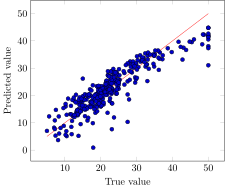

In [13]:
# Plot true values versus predicted values for linear regression on training set
linearreg_plot_training = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    linearreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )
# PredictMD.open(linearreg_plot_training)

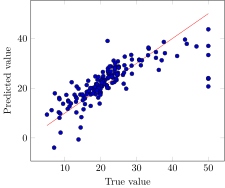

In [14]:
# Plot true values versus predicted values for linear regression on testing set
linearreg_plot_testing = PredictMD.plotsinglelabelregressiontrueversuspredicted(
    linearreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname
    )
# PredictMD.open(linearreg_plot_testing)

In [15]:
# Evaluate performance of linear regression on training set
PredictMD.singlelabelregressionmetrics(
    linearreg,
    trainingfeaturesdf,
    traininglabelsdf,
    labelname,
    )

,metric,Linear regression
1,R^2 (coefficient of determination),0.800524


In [16]:
# Evaluate performance of linear regression on testing set
PredictMD.singlelabelregressionmetrics(
    linearreg,
    testingfeaturesdf,
    testinglabelsdf,
    labelname,
    )

,metric,Linear regression
1,R^2 (coefficient of determination),0.59293


### Section 4: Save trained models to file (if desired)

In [17]:
if save_trained
    PredictMD.save(linearreg_filename, linearreg)
end

INFO: Saved model to file ./linearreg.jld2


### Appendix A: Directly access the output of regression models

In [18]:
# We can use the PredictMD.predict() function to get the real-valued predictions
# output by each of regression models.

# Get real-valued predictions from each model for training set
PredictMD.predict(linearreg,trainingfeaturesdf,)

# Get real-valued predictions from each model for testing set
PredictMD.predict(linearreg,testingfeaturesdf,)

,MedV
1,17.3076
2,43.6842
3,20.71
4,16.6776
5,25.3328
6,9.3874
7,-3.90867
8,19.7898
9,34.528
10,20.0962
